<a href="https://colab.research.google.com/github/SihanWu123/OPTI556HW2/blob/main/OPTI556HW2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sihan Wu 
#OPTI556 HW2.2
#23553196

Figures 3.4 and 3.5 compare ordinary least squares, truncated SVD, Tikhonov and LASSO reconstructions for sparse spectra. Repeat these simulations for several different spectra in the Chianti database using several different measurement matrices, including random, Hadamard and downsampling forward models. Try several different noise levels. Compare the performance of each of the regression algorithms for different measurement and noise models.

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy.linalg import toeplitz
from scipy.linalg import hadamard
import random
from sklearn import linear_model
from skimage import filters

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 15]
plt.rcParams.update({'font.size': 22})

In [ ]:

!wget https://download.chiantidatabase.org/CHIANTI_10.0.1_database.tar.gz
!mkdir dbase
!tar xvf CHIANTI_10.0.1_database.tar.gz -C dbase/

--2021-09-28 23:26:27--  https://download.chiantidatabase.org/CHIANTI_10.0.1_database.tar.gz
Resolving download.chiantidatabase.org (download.chiantidatabase.org)... 70.32.23.63
Connecting to download.chiantidatabase.org (download.chiantidatabase.org)|70.32.23.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 888202017 (847M) [application/x-gzip]
Saving to: ‘CHIANTI_10.0.1_database.tar.gz’

CHIANTI_10.0.1_data 100%[===================>] 847.05M  46.7MB/s    in 19s     

2021-09-28 23:26:46 (45.5 MB/s) - ‘CHIANTI_10.0.1_database.tar.gz’ saved [888202017/888202017]

README_CHIANTI
VERSION
abundance/
abundance/sun_coronal_2012_schmelz_ext.abund
abundance/cosmic_1973_allen.abund
abundance/sun_photospheric_2011_caffau.abund
abundance/sun_photospheric_2015_scott.abund
abundance/unity.abund
abundance/sun_coronal_1999_fludra_ext.abund
abundance/sun_photospheric_1998_grevesse.abund
abundance/sun_coronal_1992_feldman_ext.abund
abundance/sun_coronal_1999_fludra.abund
ab

In [2]:
!pip3 install ChiantiPy
!pip3 install ipyparallel
%env XUVTOP=/content/dbase/

     |████████████████████████████████| 189 kB 5.2 MB/s 
     |████████████████████████████████| 384 kB 5.1 MB/s 
env: XUVTOP=/content/dbase/


In [ ]:
import ChiantiPy.core as ch

 ChiantiPy version 0.11.0 
 using cli
 using CLI for selections


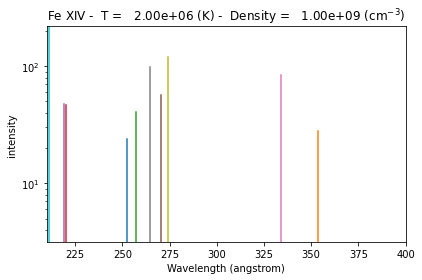

In [ ]:
t=2000000
fe14 = ch.ion('fe_14', temperature=t, eDensity=1.e+9, em=1.e+27)
fe14.intensityPlot(wvlRange=[210.,400.],linLog='log')
wvl = np.linspace(100,400,1024)
fe14.spectrum(wvl)

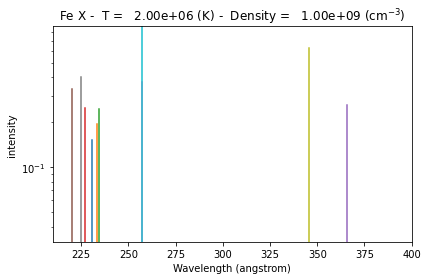

In [ ]:
t=2000000
fe10 = ch.ion('fe_10', temperature=t, eDensity=1.e+9, em=1.e+27)
fe10.intensityPlot(wvlRange=[210.,400.],linLog='log')
wvl = np.linspace(100,400,1024)
fe10.spectrum(wvl)

In [ ]:
def MyShow(I_olsran, I_tsvdran, I_tiknovran, I_lassoran, I_olshad, I_tsvdhad, I_tiknovhad, I_lassohad,I_olsdownsp, I_tsvddownsp, I_tiknovdownsp, I_lassodownsp):
 fig, axs = plt.subplots(3, 4)

 axs[0,0].plot(wvl,I_olsran)
 axs[0,0].set_title('OLS')
 axs[0,0].set(ylabel = 'random')
 
 axs[0,1].plot(wvl,I_tsvdran)
 axs[0,1].set_title('tSVD')
 
 axs[0,2].plot(wvl,I_tiknovran)
 axs[0,2].set_title('tikhonov')

 axs[0,3].plot(wvl,I_lassoran)
 axs[0,3].set_title('LASSO')
 
 axs[1,0].plot(wvl,I_olshad)
 axs[1,0].set(ylabel = 'Hadamard')
 
 axs[1,1].plot(wvl,I_tsvdhad)

 axs[1,2].plot(wvl,I_tiknovhad)
 
 axs[1,3].plot(wvl,I_lassohad)

 axs[2,0].plot(wvl,I_olsdownsp)
 axs[2,0].set(ylabel = 'downsampling')
 
 axs[2,1].plot(wvl,I_tsvddownsp)
 
 axs[2,2].plot(wvl,I_tiknovdownsp)
 
 axs[2,3].plot(wvl,I_lassodownsp)

 
  

In [ ]:
# Create different measurement matrices 
R=1024
# random matrix
H_random = np.random.random((R,1024))-.5
u_random, lam_random, vh_random = np.linalg.svd(H_random)

# Hadamard matrix
H_hadmard = hadamard(R)
u_hadmard, lam_hadamard, vh_hadamard = np.linalg.svd(H_hadmard)

# downsampling matrix 
array = np.random.randint(0,1023,size=(100))
H1 = np.ones(1024)

for i in range(0,99):
  H1[array[i]] = 0

H_downsampling = np.diag(H1)
u_downsampling, lam_downsampling, vh_downsampling = np.linalg.svd(H_downsampling)

In [ ]:
# measurements with different matrices
noiseLevel=3
meas_random=np.matmul(H_random,fe14.Spectrum['intensity'])+noiseLevel*np.random.normal(scale=1,size=(1024))
meas_hadamard=np.matmul(H_hadmard,fe14.Spectrum['intensity'])+noiseLevel*np.random.normal(scale=1,size=(1024))
meas_downsampling=np.matmul(H_downsampling,fe14.Spectrum['intensity'])+noiseLevel*np.random.normal(scale=1,size=(1024))

In [ ]:
# ordinary least squares for different measurements 

I_olsran=np.linalg.lstsq(H_random,meas_random)[0]
I_olshad=np.linalg.lstsq(H_hadmard, meas_hadamard)[0]
I_olsdownsp=np.linalg.lstsq(H_downsampling, meas_downsampling)[0]


# truncated SVD for different measurements 
reduceRank=900
Hr_random=np.matmul(np.matmul(np.transpose(vh_random[0:reduceRank,:]),np.diag(1./lam_random[0:reduceRank])),np.transpose(u_random[:,0:reduceRank]))
Hr_hadamard=np.matmul(np.matmul(np.transpose(vh_hadamard[0:reduceRank,:]),np.diag(1./lam_hadamard[0:reduceRank])),np.transpose(u_hadmard[:,0:reduceRank]))
Hr_downsampling=np.matmul(np.matmul(np.transpose(vh_downsampling[0:reduceRank,:]),np.diag(1./lam_downsampling[0:reduceRank])),np.transpose(u_downsampling[:,0:reduceRank]))

I_tsvdran=np.matmul(Hr_random, meas_random)
I_tsvdhad=np.matmul(Hr_hadamard, meas_hadamard)
I_tsvddownsp=np.matmul(Hr_downsampling,meas_downsampling)


# tikhonov for different measurements 
lpam=1
I_tiknovran=np.matmul(np.matmul(np.linalg.pinv(np.matmul(np.transpose(H_random),H_random)+lpam**2*np.eye(1024)),np.transpose(H_random)), meas_random)
I_tiknovhad=np.matmul(np.matmul(np.linalg.pinv(np.matmul(np.transpose(H_hadmard),H_hadmard)+lpam**2*np.eye(1024)),np.transpose(H_hadmard)), meas_hadamard)
I_tiknovdownsp=np.matmul(np.matmul(np.linalg.pinv(np.matmul(np.transpose(H_downsampling),H_downsampling)+lpam**2*np.eye(1024)),np.transpose(H_downsampling)), meas_downsampling)


# LASSO for different measurements 
model_random = linear_model.Lasso(alpha=0.1)
model_random.fit(H_random,meas_random)
I_lassoran=model_random.coef_
model_hadamard = linear_model.Lasso(alpha=0.1)
model_hadamard.fit(H_hadmard,meas_hadamard)
I_lassohad=model_hadamard.coef_
model_downsampling = linear_model.Lasso(alpha=0.1)
model_downsampling.fit(H_downsampling,meas_downsampling)
I_lassodownsp=model_downsampling.coef_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the

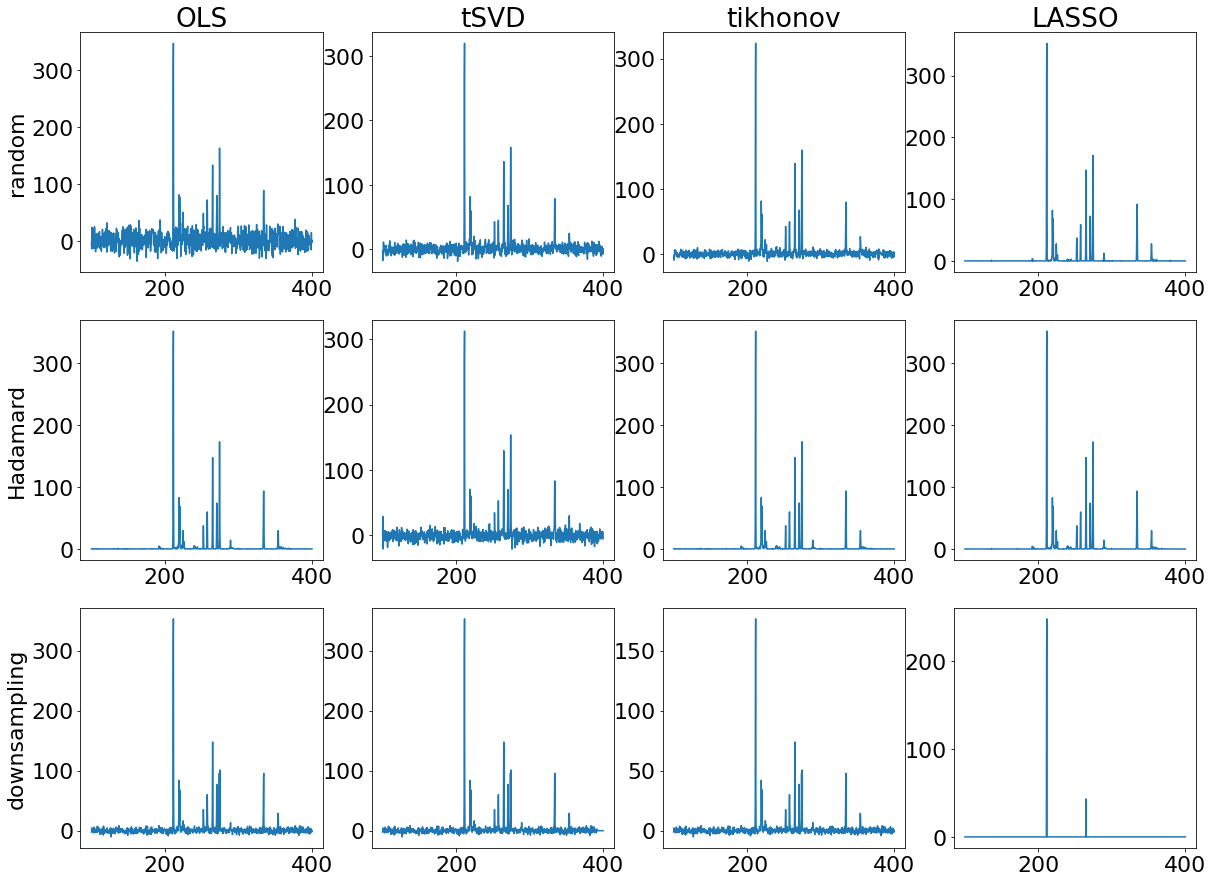

In [ ]:
MyShow(I_olsran, I_tsvdran, I_tiknovran, I_lassoran, I_olshad, I_tsvdhad, I_tiknovhad, I_lassohad,I_olsdownsp, I_tsvddownsp, I_tiknovdownsp, I_lassodownsp)

According to figure above, we can see that results of OLS when using random matrix is the worst compared to downsampling and Hadamard,. 

In [ ]:
# measurements of different matrices with noise level of 10
noiseLevel=10
meas_random=np.matmul(H_random,fe14.Spectrum['intensity'])+noiseLevel*np.random.normal(scale=1,size=(1024))
meas_hadamard=np.matmul(H_hadmard,fe14.Spectrum['intensity'])+noiseLevel*np.random.normal(scale=1,size=(1024))
meas_downsampling=np.matmul(H_downsampling,fe14.Spectrum['intensity'])+noiseLevel*np.random.normal(scale=1,size=(1024))

In [ ]:
# ordinary least squares for different measurements 

I_olsran=np.linalg.lstsq(H_random,meas_random)[0]
I_olshad=np.linalg.lstsq(H_hadmard, meas_hadamard)[0]
I_olsdownsp=np.linalg.lstsq(H_downsampling, meas_downsampling)[0]


# truncated SVD for different measurements 
reduceRank=900
Hr_random=np.matmul(np.matmul(np.transpose(vh_random[0:reduceRank,:]),np.diag(1./lam_random[0:reduceRank])),np.transpose(u_random[:,0:reduceRank]))
Hr_hadamard=np.matmul(np.matmul(np.transpose(vh_hadamard[0:reduceRank,:]),np.diag(1./lam_hadamard[0:reduceRank])),np.transpose(u_hadmard[:,0:reduceRank]))
Hr_downsampling=np.matmul(np.matmul(np.transpose(vh_downsampling[0:reduceRank,:]),np.diag(1./lam_downsampling[0:reduceRank])),np.transpose(u_downsampling[:,0:reduceRank]))

I_tsvdran=np.matmul(Hr_random, meas_random)
I_tsvdhad=np.matmul(Hr_hadamard, meas_hadamard)
I_tsvddownsp=np.matmul(Hr_downsampling,meas_downsampling)


# tikhonov for different measurements 
lpam=1
I_tiknovran=np.matmul(np.matmul(np.linalg.pinv(np.matmul(np.transpose(H_random),H_random)+lpam**2*np.eye(1024)),np.transpose(H_random)), meas_random)
I_tiknovhad=np.matmul(np.matmul(np.linalg.pinv(np.matmul(np.transpose(H_hadmard),H_hadmard)+lpam**2*np.eye(1024)),np.transpose(H_hadmard)), meas_hadamard)
I_tiknovdownsp=np.matmul(np.matmul(np.linalg.pinv(np.matmul(np.transpose(H_downsampling),H_downsampling)+lpam**2*np.eye(1024)),np.transpose(H_downsampling)), meas_downsampling)


# LASSO for different measurements 
model_random = linear_model.Lasso(alpha=0.1)
model_random.fit(H_random,meas_random)
I_lassoran=model_random.coef_
model_hadamard = linear_model.Lasso(alpha=0.1)
model_hadamard.fit(H_hadmard,meas_hadamard)
I_lassohad=model_hadamard.coef_
model_downsampling = linear_model.Lasso(alpha=0.1)
model_downsampling.fit(H_downsampling,meas_downsampling)
I_lassodownsp=model_downsampling.coef_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the

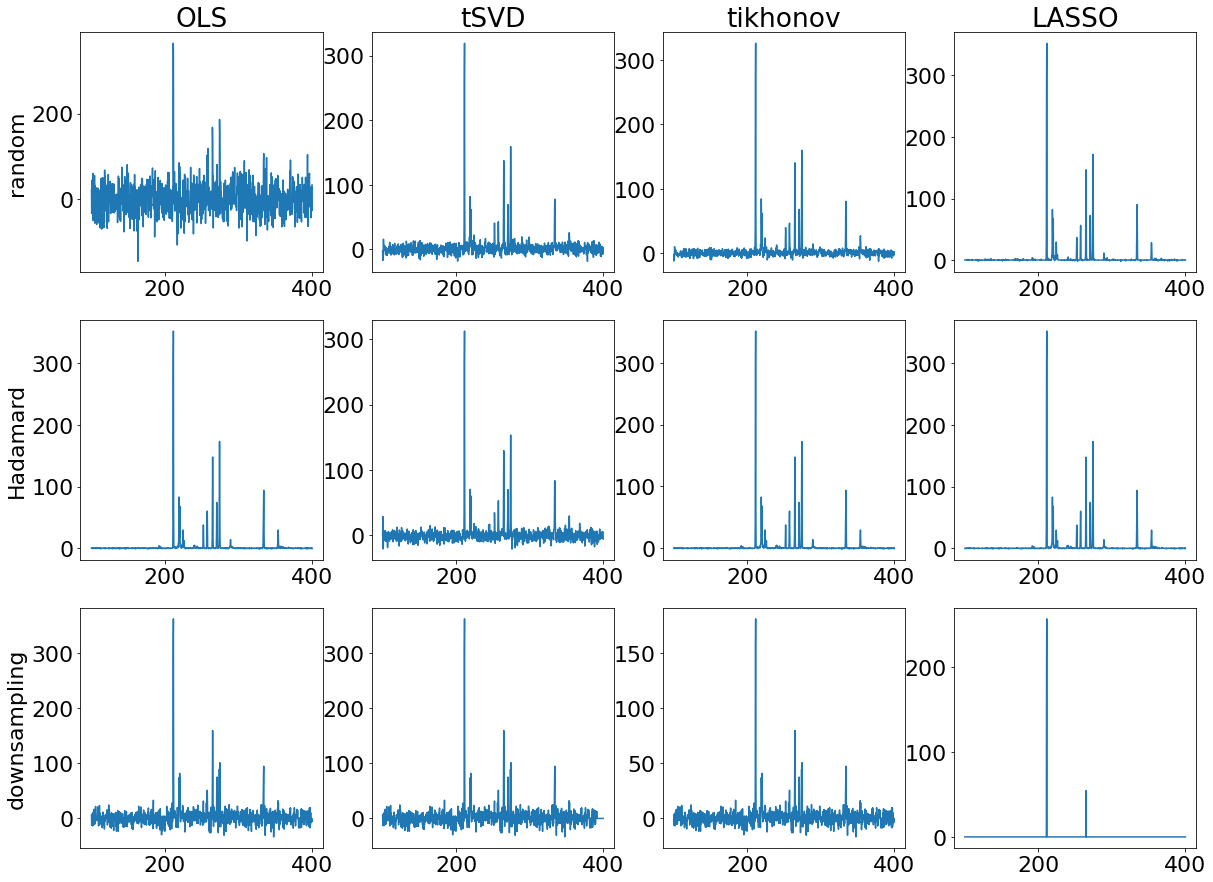

In [ ]:
MyShow(I_olsran, I_tsvdran, I_tiknovran, I_lassoran, I_olshad, I_tsvdhad, I_tiknovhad, I_lassohad,I_olsdownsp, I_tsvddownsp, I_tiknovdownsp, I_lassodownsp)

In [ ]:
# measurements with different matrices with noise level of 0.1
noiseLevel=0.1
meas_random=np.matmul(H_random,fe14.Spectrum['intensity'])+noiseLevel*np.random.normal(scale=1,size=(1024))
meas_hadamard=np.matmul(H_hadmard,fe14.Spectrum['intensity'])+noiseLevel*np.random.normal(scale=1,size=(1024))
meas_downsampling=np.matmul(H_downsampling,fe14.Spectrum['intensity'])+noiseLevel*np.random.normal(scale=1,size=(1024))

In [ ]:
# ordinary least squares for different measurements 

I_olsran=np.linalg.lstsq(H_random,meas_random)[0]
I_olshad=np.linalg.lstsq(H_hadmard, meas_hadamard)[0]
I_olsdownsp=np.linalg.lstsq(H_downsampling, meas_downsampling)[0]


# truncated SVD for different measurements 
reduceRank=900
Hr_random=np.matmul(np.matmul(np.transpose(vh_random[0:reduceRank,:]),np.diag(1./lam_random[0:reduceRank])),np.transpose(u_random[:,0:reduceRank]))
Hr_hadamard=np.matmul(np.matmul(np.transpose(vh_hadamard[0:reduceRank,:]),np.diag(1./lam_hadamard[0:reduceRank])),np.transpose(u_hadmard[:,0:reduceRank]))
Hr_downsampling=np.matmul(np.matmul(np.transpose(vh_downsampling[0:reduceRank,:]),np.diag(1./lam_downsampling[0:reduceRank])),np.transpose(u_downsampling[:,0:reduceRank]))

I_tsvdran=np.matmul(Hr_random, meas_random)
I_tsvdhad=np.matmul(Hr_hadamard, meas_hadamard)
I_tsvddownsp=np.matmul(Hr_downsampling,meas_downsampling)


# tikhonov for different measurements 
lpam=1
I_tiknovran=np.matmul(np.matmul(np.linalg.pinv(np.matmul(np.transpose(H_random),H_random)+lpam**2*np.eye(1024)),np.transpose(H_random)), meas_random)
I_tiknovhad=np.matmul(np.matmul(np.linalg.pinv(np.matmul(np.transpose(H_hadmard),H_hadmard)+lpam**2*np.eye(1024)),np.transpose(H_hadmard)), meas_hadamard)
I_tiknovdownsp=np.matmul(np.matmul(np.linalg.pinv(np.matmul(np.transpose(H_downsampling),H_downsampling)+lpam**2*np.eye(1024)),np.transpose(H_downsampling)), meas_downsampling)


# LASSO for different measurements 
model_random = linear_model.Lasso(alpha=0.1)
model_random.fit(H_random,meas_random)
I_lassoran=model_random.coef_
model_hadamard = linear_model.Lasso(alpha=0.1)
model_hadamard.fit(H_hadmard,meas_hadamard)
I_lassohad=model_hadamard.coef_
model_downsampling = linear_model.Lasso(alpha=0.1)
model_downsampling.fit(H_downsampling,meas_downsampling)
I_lassodownsp=model_downsampling.coef_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the

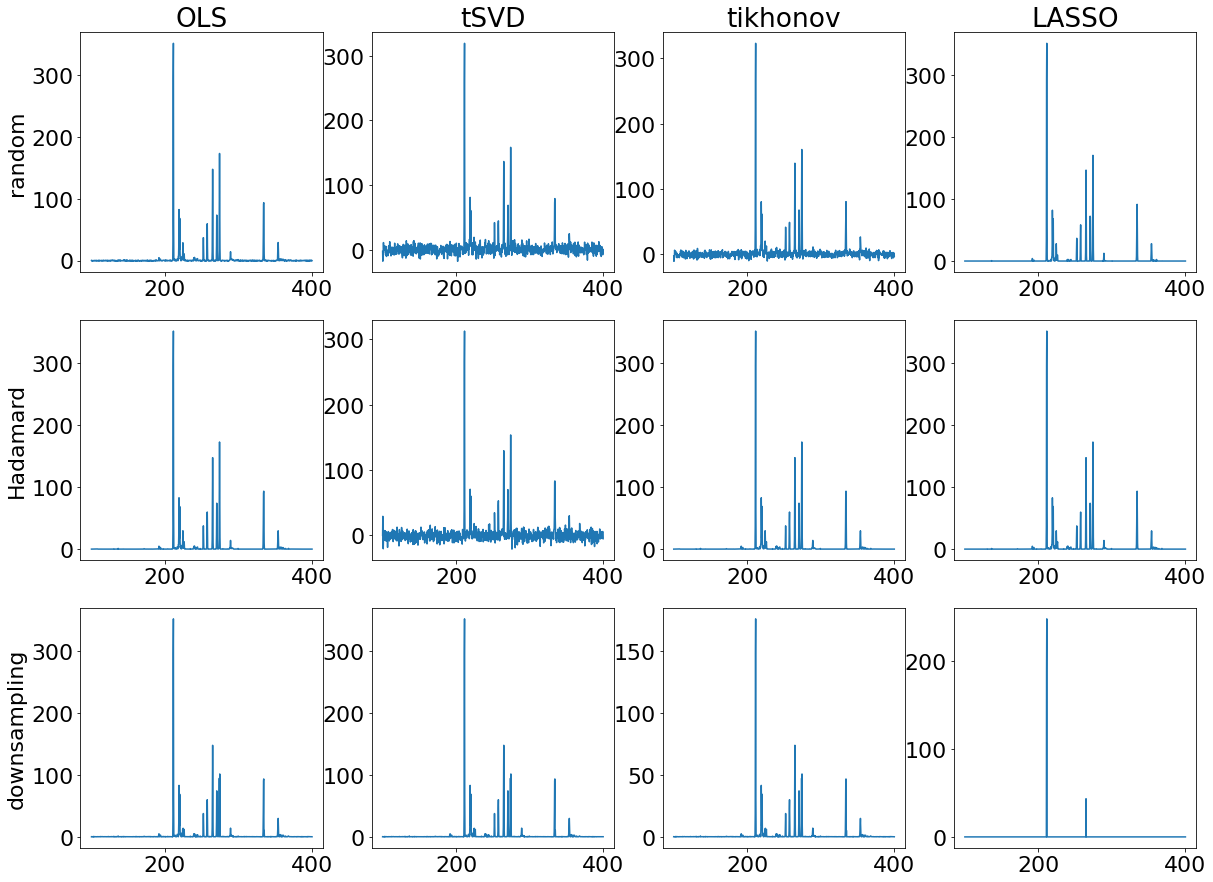

In [ ]:
MyShow(I_olsran, I_tsvdran, I_tiknovran, I_lassoran, I_olshad, I_tsvdhad, I_tiknovhad, I_lassohad,I_olsdownsp, I_tsvddownsp, I_tiknovdownsp, I_lassodownsp)

In this problem, we tryed three different measurment matrices and three different noise level. For random matrix, we can see that LASSO has the best performance no matter what nosise level is. And OLS has the worst performance especially when noise level is high. Noise level has little effect when using Truncated SVD and tikhonov algorithm. For Hadamard matrix, we can see that OLS, tikhonov and LASSO have good performance except for tSVD. And when using Hadamard matrix, noise level do not have much effect. For downsampling case, we can see that OLS, tSVD and tikhonov have similar performance. And they are all affected by noise level. Noise level does not affect LASSO. But some terms in LASSO cannot be recovered. 